In [17]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import LSTM,Lambda,Conv1D,Conv2D,Bidirectional,Dense,Dropout,Input
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/solarwind.csv')

In [5]:
data.head()

,period,timedelta,t0,t1,bt_mean,bt_std,temperature_mean,temperature_std,bx_gse_mean,bx_gse_std,by_gse_mean,by_gse_std,bz_gse_mean,bz_gse_std,speed_mean,speed_std,density_mean,density_std,smoothed_ssn
0,train_a,0 days 00:00:00,-7,-10.0,0.499705,2.443614,-0.375267,0.383941,-1.599207,-0.381502,0.419516,0.031658,0.300358,-0.651645,-0.738546,0.862524,-0.775827,-0.205724,0.139444
1,train_a,0 days 01:00:00,-10,-10.0,0.547177,-0.224580,-0.479430,0.953178,-1.757995,-0.867747,0.179257,-0.272971,0.446103,-0.517913,-0.986904,0.995063,-0.861692,-0.058215,0.139444
2,train_a,0 days 02:00:00,-10,-6.0,0.739905,-0.770240,-0.574831,-0.192518,-1.912116,-1.114317,0.183266,-0.822786,0.770174,-0.876490,-1.013548,0.554085,-0.846222,-0.220012,0.139444
3,train_a,0 days 03:00:00,-6,-2.0,0.699098,-0.278783,-0.324709,0.325491,-1.809045,-0.783042,-0.378111,0.341156,0.621194,-0.290211,-0.826469,-0.211185,-0.404306,0.218373,0.139444
4,train_a,0 days 04:00:00,-2,3.0,0.223933,-0.225168,-0.313432,0.201600,-1.338802,-0.484910,0.072745,1.023019,0.467629,-0.478080,-0.601238,1.016033,-0.371487,0.097253,0.139444


In [6]:
def get_train_test_val(data, test_per_period, val_per_period):
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    val = data.groupby("period").tail(val_per_period)
    train = interim[~interim.index.isin(val.index)]
    return train, test, val

In [7]:
train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [8]:
batch_size = 32
timesteps = 32

In [9]:
SOLAR_WIND_FEATURES = ["bt","temperature","bx_gse", "by_gse","bz_gse","speed","density"]
XCOLS = ([col + "_mean" for col in SOLAR_WIND_FEATURES] + [col + "_std" for col in SOLAR_WIND_FEATURES] + ["smoothed_ssn"])
YCOLS = ["t0", "t1"]

In [10]:
def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    for _, period_df in df.groupby("period"):
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]
        period_ds = timeseries_dataset_from_array(inputs,outputs,timesteps,batch_size=batch_size)
        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)
    return dataset

In [11]:
train_ds = timeseries_dataset_from_df(train,batch_size)
val_ds = timeseries_dataset_from_df(val, batch_size)

In [15]:
print("Number of train batches:",len(train_ds)) 
print("Number of val batches:",len(val_ds))

Number of train batches: 3804
Number of val batches: 276


In [16]:
cnt = 0
for i in train_ds:
  print(i)
  cnt += 1
  if(cnt==1):
    break

(<tf.Tensor: shape=(32, 32, 15), dtype=float64, numpy=
array([[[ 0.49970532, -0.3752665 , -1.59920742, ...,  0.8625241 ,
         -0.20572399,  0.13944356],
        [ 0.54717706, -0.47942961, -1.75799547, ...,  0.99506251,
         -0.0582153 ,  0.13944356],
        [ 0.73990464, -0.57483108, -1.91211616, ...,  0.55408547,
         -0.2200116 ,  0.13944356],
        ...,
        [ 0.40006385, -0.54059931, -0.48705897, ..., -0.43224376,
          0.13598695,  0.13944356],
        [ 0.24001747, -0.53209255, -0.0566879 , ...,  0.23885405,
          0.10714622,  0.13944356],
        [ 0.47502996, -0.77966259, -0.23188884, ..., -0.18703237,
         -0.19174087,  0.13944356]],

       [[ 0.54717706, -0.47942961, -1.75799547, ...,  0.99506251,
         -0.0582153 ,  0.13944356],
        [ 0.73990464, -0.57483108, -1.91211616, ...,  0.55408547,
         -0.2200116 ,  0.13944356],
        [ 0.69909752, -0.32470916, -1.80904491, ..., -0.21118452,
          0.21837264,  0.13944356],
        ...,

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [19]:
input_shape = (None,timesteps,len(XCOLS))

In [41]:
model = tf.keras.models.Sequential([
                                    LSTM(64,batch_input_shape=(None,timesteps,len(XCOLS)),return_sequences=True),
                                    Bidirectional(LSTM(32,return_sequences=True)),
                                    Bidirectional(LSTM(16)),
                                    Dense(10,activation= 'relu'),
                                    Dense(10,activation= 'relu'),
                                    Dense(len(YCOLS))
                                  ])

In [42]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 32, 64)            20480     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32, 64)            24832     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 22        
Total params: 56,142
Trainable params: 56,142
Non-trainable params: 0
_________________________________________________

In [43]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mean_squared_error",optimizer="adam",metrics=["accuracy"])

In [45]:
history = model.fit(
    train_ds,
    batch_size= 32,
    epochs= 5,
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    use_multiprocessing=True,
    workers= 4
)

Epoch 1/5
3804/3804 [==============================] - 164s 43ms/step - loss: 97.7616 - accuracy: 0.5167 - val_loss: 212.8866 - val_accuracy: 0.5083
Epoch 2/5
3804/3804 [==============================] - 165s 43ms/step - loss: 92.6810 - accuracy: 0.5209 - val_loss: 195.6024 - val_accuracy: 0.5115
Epoch 3/5
3804/3804 [==============================] - 164s 43ms/step - loss: 88.6595 - accuracy: 0.5217 - val_loss: 173.4022 - val_accuracy: 0.5125
Epoch 4/5
3804/3804 [==============================] - 165s 43ms/step - loss: 90.0315 - accuracy: 0.5233 - val_loss: 221.6053 - val_accuracy: 0.5111
Epoch 5/5
3804/3804 [==============================] - 165s 43ms/step - loss: 81.4651 - accuracy: 0.5224 - val_loss: 205.9670 - val_accuracy: 0.5145


In [46]:
model.save("solarwind.h5")

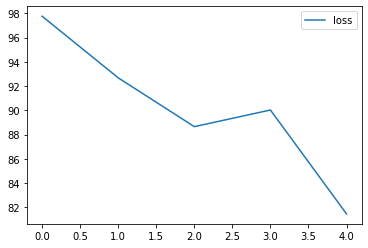

In [47]:
pd.DataFrame(history.history)[['loss']].plot();

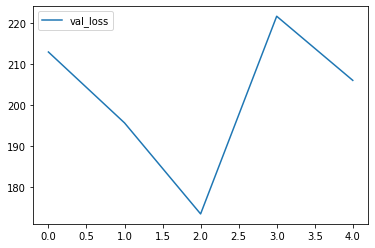

In [48]:
pd.DataFrame(history.history)[['val_loss']].plot();

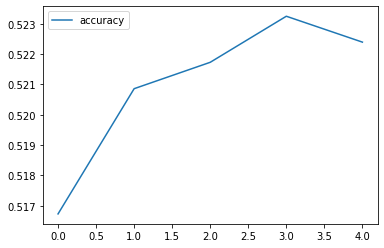

In [49]:
pd.DataFrame(history.history)[['accuracy']].plot();

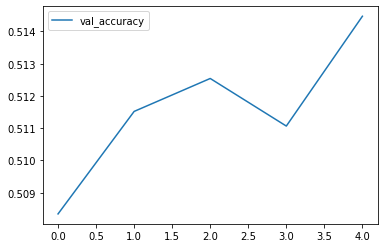

In [50]:
pd.DataFrame(history.history)[['val_accuracy']].plot();

In [51]:
test_ds = timeseries_dataset_from_df(test, batch_size)
mse = model.evaluate(test_ds)


558/558 [==============================] - 11s 19ms/step - loss: 165.5542 - accuracy: 0.5170


In [ ]:
test.to_csv("solarwind_test.csv")